In [22]:

!pip install pandas matplotlib nltk textblob wordcloud scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
import re
import nltk
from nltk import word_tokenize, ngrams
from nltk.stem import WordNetLemmatizer
import unicodedata


# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\praka\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [24]:

# Load the CSV file
df = pd.read_csv('drugComments.csv', encoding='unicode_escape')
df.head()


,id,drugName,rating,effectiveness,sideEffects,condition,benefitsReview,sideEffectsReview,commentsReview
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,NaN,NaN
1,alone or with other agents in the managment of...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"mangagement of congestive heart failur""","cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",NaN,NaN,NaN,NaN,NaN,NaN
3,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
4,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...


In [25]:

def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'#', '', text)
        text = re.sub(r'https?:\/\/\S+', '', text)
        text = re.sub(r'[0-9]+|[^\w\s]', '', text)
        return text
    return text

df['benefitsReview'] = df['benefitsReview'].apply(clean_text)
df['benefitsReview'] = df['benefitsReview'].fillna('')
df['benefitsReview'].head()


0    slowed the progression of left ventricular dys...
1                                                     
2                                                     
3    although this type of birth control has more c...
4    i was used to having cramps so badly that they...
Name: benefitsReview, dtype: object

In [27]:

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

cv = CountVectorizer(tokenizer=LemmaTokenizer(), stop_words='english', max_df=0.75)
counts = cv.fit_transform(df['benefitsReview'])
DT_matrix = pd.DataFrame(counts.toarray(), columns=cv.get_feature_names_out())
DT_matrix.head()


C:\Users\praka\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Users\praka\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


,aand,aarm,abaitment,abated,abatement,abcess,abcessed,abcesses,abdomen,abdomin,...,zoster,zovirax,zoviraxacyclovir,zpak,zyban,zybanbupropion,zydol,zyprexa,zyrtec,zyvox
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


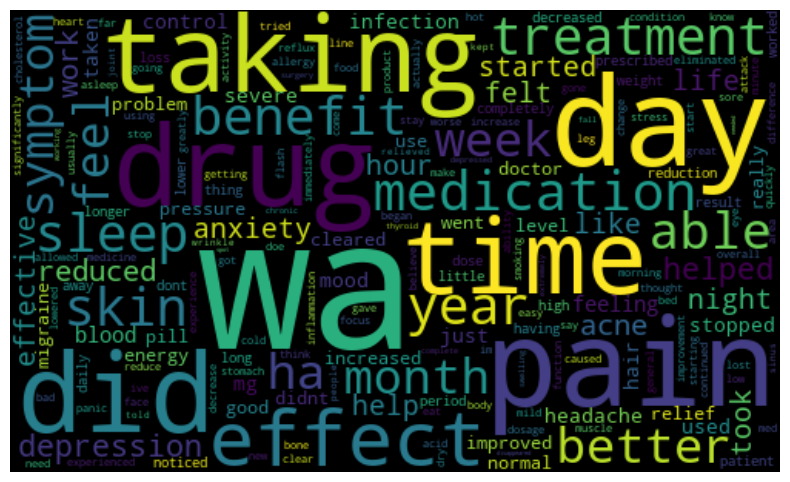

In [28]:

stop_words = ["project", "PMP", "Project"] + list(STOPWORDS)
word_freq = dict(zip(DT_matrix.columns, DT_matrix.sum(axis=0)))
wc = WordCloud(stopwords=stop_words, width=500, height=300, random_state=21, max_font_size=119)
wc.generate_from_frequencies(word_freq)
plt.figure(figsize=(10, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()


In [29]:

tf = cv.fit_transform(df['benefitsReview']).toarray()
tf_feature_names = cv.get_feature_names_out()

lda = LatentDirichletAllocation(n_components=6, learning_method="batch", max_iter=25, random_state=0)
lda.fit(tf)

def display_topics(model, feature_names, no_top_words):
    return pd.DataFrame({
        f"Topic {i+1}": [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        for i, topic in enumerate(model.components_)
    })

display_topics(lda, tf_feature_names, 10)


C:\Users\praka\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6
0,wa,wa,wa,skin,wa,night
1,able,blood,depression,wa,drug,sleep
2,pain,headache,drug,acne,hair,wa
3,better,pain,taking,day,pain,hot
4,day,pressure,effect,did,effect,asleep
5,felt,migraine,treatment,month,did,flash
6,feeling,symptom,benefit,benefit,medication,drug
7,time,reduced,day,treatment,year,day
8,feel,relief,did,week,taking,feel
9,mood,medication,life,cleared,loss,hour


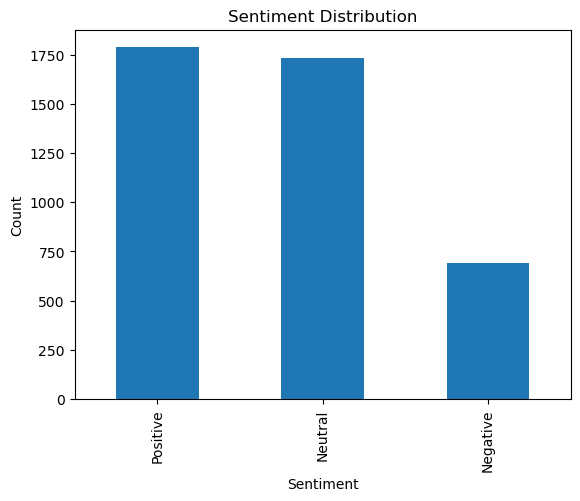

In [30]:

df['Subjectivity'] = df['benefitsReview'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['Polarity'] = df['benefitsReview'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['Sentiment'] = df['Polarity'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

df['Sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()
